# ML Developer Case Study - Utku Ozkan

## Business Understanding

      • Performing RFM Analysis of the data belonging to an Online shopping site and explaining the results.
      

In [1]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import squarify
import datetime as dt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
from warnings import filterwarnings    # For error messages
filterwarnings('ignore')

In [3]:
data = pd.read_csv('./online_retail.csv',encoding = 'unicode_escape')   

## Data Understanding

### Dataset information;

In [4]:
data.shape

(541909, 8)

In [5]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [7]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


#### Descriptions of Columns in a Dataset ;

     • InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
     
     • StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
     
     • Description: Product (item) name. Nominal.
     
     • Quantity: The quantities of each product (item) per transaction. Numeric.
     
     • InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
     
     • UnitPrice: Unit price. Numeric, Product price per unit in sterling.
     
     • Customer ID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
     
     • Country: Country name. Nominal, the name of the country where each customer resides.

## Data Preparation

In [9]:
# Have to change the InviceDate data type to date.
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


     * Negative values are seen in Quantity and UnitPrice. For this, the rows containing 'C' in the Invoice column, that is Cancel (returned), should be removed from the data set.
     

In [11]:
data = data[~data["InvoiceNo"].str.contains("C", na=False)]

In [12]:
data.describe().T  

,count,mean,std,min,25%,50%,75%,max
Quantity,532621.0,10.239972,159.593551,-9600.00,1.00,3.00,10.00,80995.00
UnitPrice,532621.0,3.847621,41.758023,-11062.06,1.25,2.08,4.13,13541.33
CustomerID,397924.0,15294.315171,1713.169877,12346.00,13969.00,15159.00,16795.00,18287.00


     * still have negative values. Only positive values should be taken for both columns.

In [13]:
data = data[data['Quantity'] > 0]
data = data[data['UnitPrice'] > 0]

In [14]:
data.describe().T  # check

,count,mean,std,min,25%,50%,75%,max
Quantity,530104.0,10.542037,155.524124,1.000,1.00,3.00,10.00,80995.00
UnitPrice,530104.0,3.907625,35.915681,0.001,1.25,2.08,4.13,13541.33
CustomerID,397884.0,15294.423453,1713.141560,12346.000,13969.00,15159.00,16795.00,18287.00


     * Total price column should be added for Monetary.

In [15]:
data['TotalPrice'] = data['UnitPrice']*data['Quantity']

In [16]:
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [17]:
u_df = data.copy()
u_df.groupby("Country").agg({"TotalPrice": "mean"}).sort_values("TotalPrice", ascending=False).head(10) #average spending by country top 10

,TotalPrice
Country,
Netherlands,121.003111
Australia,117.192310
Japan,116.561900
Singapore,95.852658
Sweden,85.096075
Hong Kong,55.252817
Denmark,49.882474
Lithuania,47.458857
Bahrain,41.896667


In [18]:
u_df = u_df.groupby("Country").agg({"TotalPrice": "mean"}).sort_values("TotalPrice", ascending=False)
u_df.reset_index(inplace=True)

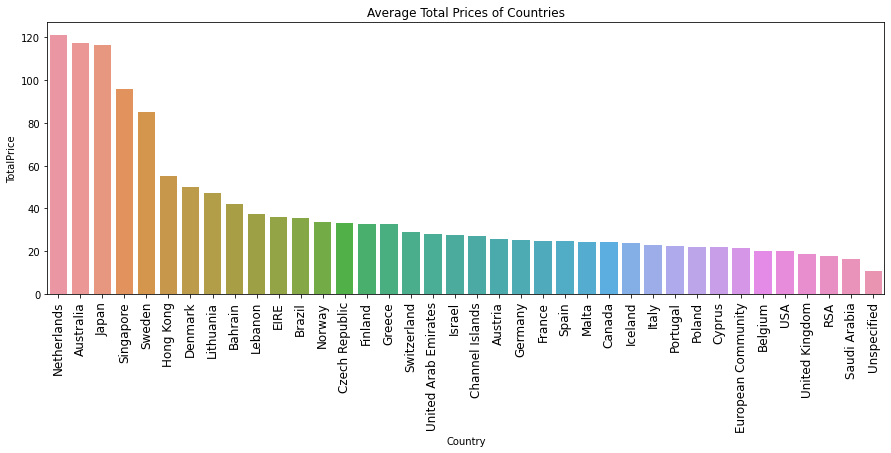

In [19]:
def mean_price(DataFrame): 
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='Country', y='TotalPrice', data=u_df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=12)
    plt.title("Average Total Prices of Countries")
mean_price(u_df)                                           

## Modeling

### RFM Analysis

#### Calculating RFM Metrics

     * For the recency value, the last shopping date should be subtracted from today.
    

In [20]:
data["InvoiceDate"].min()  

Timestamp('2010-12-01 08:26:00')

In [21]:
data["InvoiceDate"].max()  

Timestamp('2011-12-09 12:50:00')

* The dataset contains old data, it would be more accurate to take today as 01.01.2012.

In [22]:
today = dt.datetime(2012,1,1)
print(today)

2012-01-01 00:00:00


In [23]:
data_x = data.groupby('CustomerID').agg({'TotalPrice': lambda x: x.sum(),  # monetary value per capita.

                                        'InvoiceDate': lambda x: (today - x.max()).days}) # Subtract the last shopping date from the beginning of 2012


#Make should InvoiceNo unique.
data_y = data.groupby(['CustomerID','InvoiceNo']).agg({'TotalPrice': lambda x: x.sum()}) # I first aggregate on the basis of customerID and InvoiceNo



data_z = data_y.groupby('CustomerID').agg({'TotalPrice': lambda x: len(x)}) # After counting the total price on the basis of Customer ID, the frequency per person was found.


#RFM tablosuna ulaşmış oluyoruz.
rfm_table= pd.merge(data_x,data_z, on='CustomerID')  # I used merge to combine total shopping amount and total spending by CustomerID.


#Sütun isimlerini belirliyoruz
rfm_table.rename(columns= {'InvoiceDate': 'Recency',
                          'TotalPrice_y': 'Frequency',
                          'TotalPrice_x': 'Monetary'}, inplace= True)


In [24]:
rfm_table.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,77183.60,347,1
12347.0,4310.00,24,7
12348.0,1797.24,97,4
12349.0,1757.55,40,1
12350.0,334.40,332,1


* For each metric, I must divide it into 5 equal parts.

In [25]:
rfm_table["RecencyScore"] = pd.qcut(rfm_table['Recency'], 5, labels = [5, 4, 3, 2, 1])   
rfm_table["FrequencyScore"] = pd.qcut(rfm_table['Frequency'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])
rfm_table["MonetaryScore"] = pd.qcut(rfm_table['Monetary'], 5, labels = [1, 2, 3, 4, 5])
rfm_table.head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore
CustomerID,,,,,,
12346.0,77183.60,347,1,1,1,5
12347.0,4310.00,24,7,5,5,5
12348.0,1797.24,97,4,2,4,4
12349.0,1757.55,40,1,4,1,4
12350.0,334.40,332,1,1,1,2


In [26]:
rfm_table["RFM Score"] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str) + rfm_table['MonetaryScore'].astype(str)
rfm_table.head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM Score
CustomerID,,,,,,,
12346.0,77183.60,347,1,1,1,5,115
12347.0,4310.00,24,7,5,5,5,555
12348.0,1797.24,97,4,2,4,4,244
12349.0,1757.55,40,1,4,1,4,414
12350.0,334.40,332,1,1,1,2,112


In [27]:
rfm_table["RFM Score"].unique()

array(['115', '555', '244', '414', '112', '355', '111', '114', '435',
       '315', '524', '345', '335', '223', '544', '123', '511', '324',
       '334', '413', '522', '124', '215', '445', '144', '423', '122',
       '213', '412', '455', '325', '314', '312', '214', '425', '344',
       '235', '234', '333', '133', '313', '443', '233', '554', '224',
       '113', '433', '545', '225', '411', '221', '422', '245', '424',
       '513', '534', '322', '222', '454', '432', '321', '232', '434',
       '121', '211', '323', '512', '535', '212', '311', '125', '143',
       '533', '255', '543', '523', '243', '343', '135', '444', '453',
       '532', '332', '354', '142', '254', '154', '132', '542', '442',
       '231', '541', '342', '155', '421', '242', '341', '331', '553',
       '134', '525', '431', '353', '531', '253', '131', '152', '515',
       '241', '521', '145', '153', '141', '552', '452', '551', '251'],
      dtype=object)

#### Naming  RFM Segments

In [28]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At_Risk',
    r'[1-2]5': 'Cant_Lose',
    r'3[1-2]': 'About_to_Sleep',
    r'33': 'Need_Attention',
    r'[3-4][4-5]': 'Loyal_Customers',
    r'41': 'Promising',
    r'51': 'New_Customers',
    r'[4-5][2-3]': 'Potential_Loyalists',
    r'5[4-5]': 'Champions'
}

In [29]:
rfm_table['Segment'] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(seg_map, regex=True)
rfm_table.head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM Score,Segment
CustomerID,,,,,,,,
12346.0,77183.60,347,1,1,1,5,115,Hibernating
12347.0,4310.00,24,7,5,5,5,555,Champions
12348.0,1797.24,97,4,2,4,4,244,At_Risk
12349.0,1757.55,40,1,4,1,4,414,Promising
12350.0,334.40,332,1,1,1,2,112,Hibernating


In [30]:
rfm_table

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM Score,Segment
CustomerID,,,,,,,,
12346.0,77183.60,347,1,1,1,5,115,Hibernating
12347.0,4310.00,24,7,5,5,5,555,Champions
12348.0,1797.24,97,4,2,4,4,244,At_Risk
12349.0,1757.55,40,1,4,1,4,414,Promising
12350.0,334.40,332,1,1,1,2,112,Hibernating
...,...,...,...,...,...,...,...,...
18280.0,180.60,299,1,1,2,1,121,Hibernating
18281.0,80.82,202,1,1,2,1,121,Hibernating
18282.0,178.05,29,2,5,3,1,531,Potential_Loyalists


In [31]:
rfm_table.groupby('RFM Score').agg({
'Recency': ['mean','min','max','count'],
'Frequency': ['mean','min','max','count'],
'Monetary': ['mean','min','max','count'] }).round(1).head()

Recency                 Frequency               Monetary          \
             mean  min  max count      mean min max count     mean     min   
RFM Score                                                                    
111         309.3  204  395   182       1.0   1   1   182    144.3    30.6   
112         289.1  206  395   127       1.0   1   1   127    347.7   251.2   
113         301.4  216  393    32       1.0   1   1    32    633.2   492.6   
114         290.4  227  360    17       1.0   1   1    17   1272.4  1017.7   
115         316.0  218  358     4       1.0   1   1     4  21277.6  2169.4   

                          
               max count  
RFM Score                 
111          250.0   182  
112          487.8   127  
113          922.1    32  
114         1784.7    17  
115        77183.6     4

* The rfm score of 182 people is 111. These are those who ordered 300 day ago on average and received a single product. The average spending amount is 145 £

In [32]:
rfm_table.groupby('RFM Score').size().sort_values(ascending=False)[:10]  # how many people are in rfm scores.

RFM Score
555    348
111    182
455    175
121    153
112    127
444    118
122     92
544     88
233     86
344     85
dtype: int64

In [33]:
 #customers with the best rfm score
rfm_table[rfm_table["RFM Score"]=='555']     

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM Score,Segment
CustomerID,,,,,,,,
12347.0,4310.00,24,7,5,5,5,555,Champions
12362.0,5226.23,25,10,5,5,5,555,Champions
12417.0,3649.10,25,9,5,5,5,555,Champions
12433.0,13375.87,22,7,5,5,5,555,Champions
12437.0,4951.41,23,18,5,5,5,555,Champions
...,...,...,...,...,...,...,...,...
18230.0,2810.20,31,7,5,5,5,555,Champions
18241.0,2073.09,31,17,5,5,5,555,Champions
18245.0,2567.06,29,7,5,5,5,555,Champions


In [34]:

rfm_table[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count"])

Recency        Frequency           Monetary      
                           mean count       mean count         mean count
Segment                                                                  
About_to_Sleep        74.312500   352   1.161932   352   471.994375   352
At_Risk              174.785835   593   2.876897   593  1084.535297   593
Cant_Lose            153.968254    63   8.380952    63  2796.155873    63
Champions             27.361769   633  12.413902   633  6857.935482   633
Hibernating          238.605042  1071   1.101774  1071   488.643307  1071
Loyal_Customers       54.608059   819   6.479853   819  2864.247791   819
Need_Attention        73.427807   187   2.326203   187   897.627861   187
New_Customers         28.428571    42   1.000000    42   388.212857    42
Potential_Loyalists   38.398760   484   2.010331   484  1041.222004   484
Promising             44.510638    94   1.000000    94   294.007979    94

###### description of some segments

     ♦ Champions are your best customers, who bought most recently, most often, and are heavy spenders. Reward these customers. They can become early adopters for new products and will help promote your brand.
     
     ♦ Potential Loyalists are your recent customers with average frequency and who spent a good amount. Offer membership or loyalty programs or recommend related products to upsell them and help them become your Loyalists or Champions.
     
     ♦ New Customers are your customers who have a high overall RFM score but are not frequent shoppers. Start building relationships with these customers by providing onboarding support and special offers to increase their visits.

     ♦ At Risk Customers are your customers who purchased often and spent big amounts, but haven’t purchased recently. Send them personalized reactivation campaigns to reconnect, and offer renewals and helpful products to encourage another purchase.
     
     ♦ Can’t Lose Them are customers who used to visit and purchase quite often, but haven’t been visiting recently. Bring them back with relevant promotions, and run surveys to find out what went wrong and avoid losing them to a competitor.


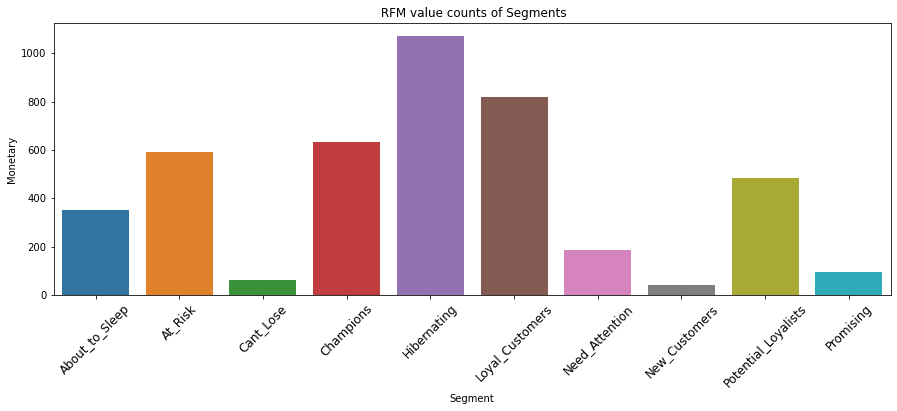

In [35]:
# Table of RFM value numbers of segments
u = rfm_table[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg("count")

u.reset_index(inplace=True)

def count_rfm_table(DataFrame): 
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='Segment', y='Monetary', data=u)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontsize=12)
    plt.title(" RFM value counts of Segments")
count_rfm_table(u)

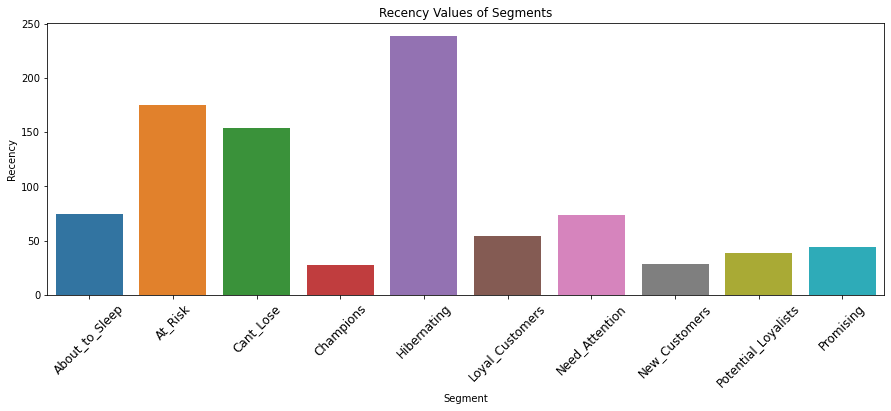

In [36]:
# Table of  Recency Values of Segments
u_1 = rfm_table[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg("mean")

u_1.reset_index(inplace=True)

def mean_recency(DataFrame):        # average recency values of each segment
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='Segment', y='Recency', data=u_1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontsize=12)
    plt.title("Recency Values of Segments")
mean_recency(u_1)
     

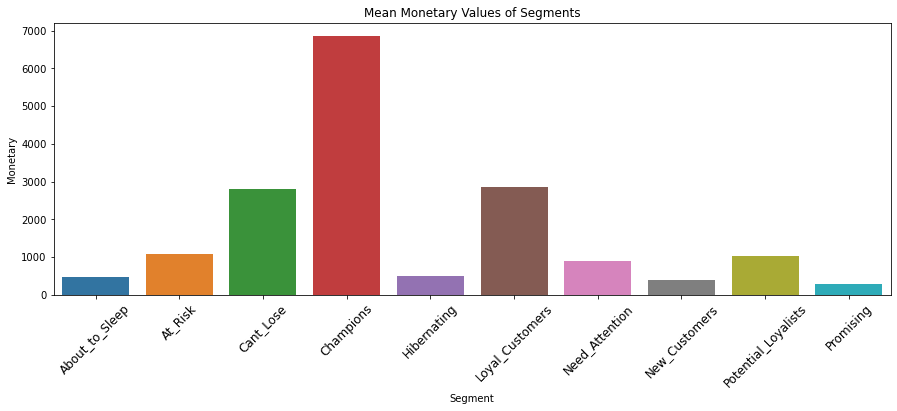

In [37]:
# table of Mean Monetary Values of Segments
def mean_monetary(DataFrame): #average monetary values of each segment 
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='Segment', y='Monetary', data=u_1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontsize=12)
    plt.title("Mean Monetary Values of Segments")
mean_monetary(u_1)

In [38]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [39]:
square_rfm = rfm_table.copy()

square_rfm.reset_index(inplace=True)

square_rfm.columns

Index(['CustomerID', 'Monetary', 'Recency', 'Frequency', 'RecencyScore',
       'FrequencyScore', 'MonetaryScore', 'RFM Score', 'Segment'],
      dtype='object')

In [40]:
square_rfm = square_rfm.groupby("Segment")["CustomerID"].nunique().sort_values(ascending=False).reset_index()

cmap = matplotlib.cm.Oranges_r
mini = min(square_rfm["CustomerID"])
maxi = max(square_rfm["CustomerID"])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)



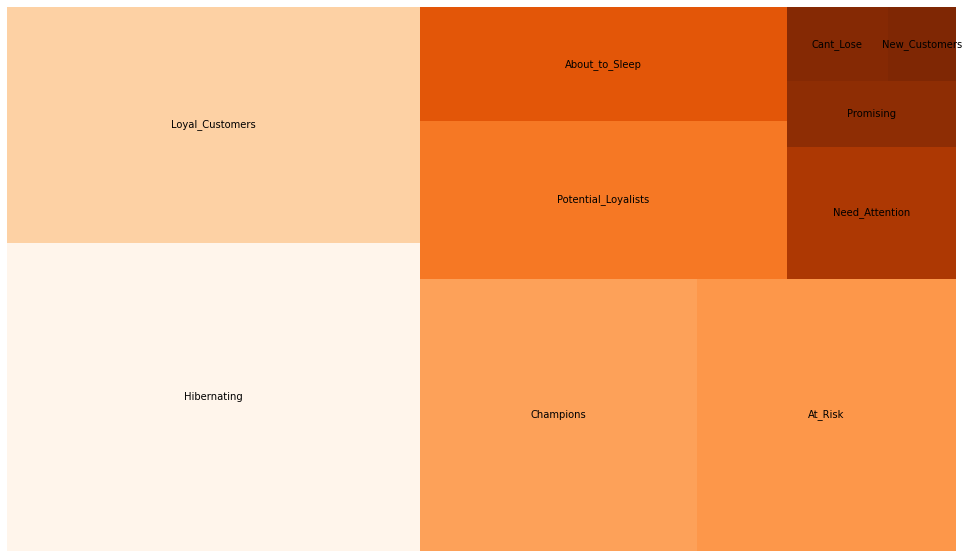

In [41]:
colors = [cmap(norm(value)) for value in square_rfm['CustomerID']]
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(17,10)
squarify.plot(sizes = square_rfm['CustomerID'], color = colors, label = square_rfm['Segment'], alpha=1)
plt.axis('off')
plt.show()
     

###  Clustering Analysis

* Density graphs of Recency, Frequency and Monetary;


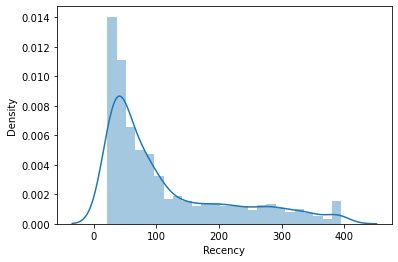

In [42]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.distplot(rfm_table['Recency'])
plt.show()

<AxesSubplot:xlabel='Frequency', ylabel='Density'>

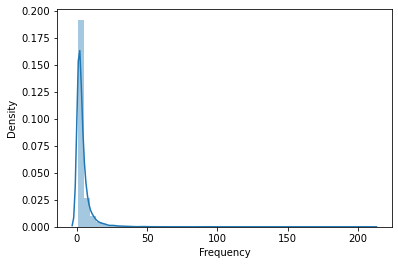

In [43]:
sns.distplot(rfm_table['Frequency'])

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

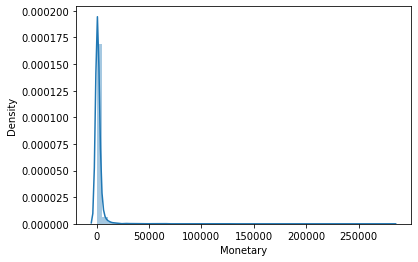

In [44]:
sns.distplot(rfm_table['Monetary'])

In [45]:
rfm_table.head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM Score,Segment
CustomerID,,,,,,,,
12346.0,77183.60,347,1,1,1,5,115,Hibernating
12347.0,4310.00,24,7,5,5,5,555,Champions
12348.0,1797.24,97,4,2,4,4,244,At_Risk
12349.0,1757.55,40,1,4,1,4,414,Promising
12350.0,334.40,332,1,1,1,2,112,Hibernating


In [46]:
clus = rfm_table[['Monetary','Recency','Frequency']]

In [47]:
clus.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,77183.60,347,1
12347.0,4310.00,24,7
12348.0,1797.24,97,4
12349.0,1757.55,40,1
12350.0,334.40,332,1


In [48]:
clusterdata=clus.iloc[:,0:4]    # customerIDs indexed.
clusterdata.head(10)

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,77183.60,347,1
12347.0,4310.00,24,7
12348.0,1797.24,97,4
12349.0,1757.55,40,1
12350.0,334.40,332,1
12352.0,2506.04,58,8
12353.0,89.00,226,1
12354.0,1079.40,254,1
12355.0,459.40,236,1


In [49]:
from sklearn.preprocessing import MinMaxScaler #It normalizes the values with the minmaxscaler.
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(clus)
data_scaled2 = pd.DataFrame(x_scaled)

In [50]:
data_scaled2.head()

,0,1,2
0,0.275443,0.871314,0.000000
1,0.015368,0.005362,0.028846
2,0.006401,0.201072,0.014423
3,0.006259,0.048257,0.000000
4,0.001180,0.831099,0.000000


In [51]:
data_scaled2.describe() # Check

,0,1,2
count,4338.000000,4338.000000,4338.000000
mean,0.007318,0.246808,0.015731
std,0.032081,0.268129,0.037010
min,0.000000,0.000000,0.000000
25%,0.001084,0.045576,0.000000
50%,0.002394,0.134048,0.004808
75%,0.005917,0.380027,0.019231
max,1.000000,1.000000,1.000000


#### Calculating the optimum number of clusters with ' The Elbow method '

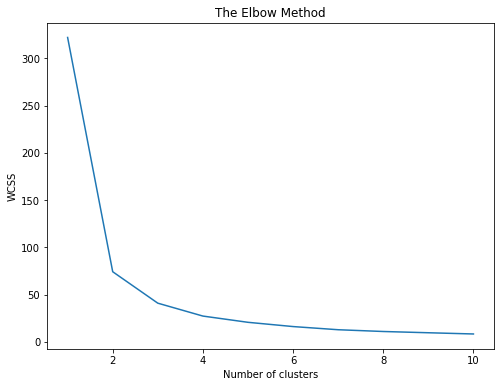

In [52]:
plt.figure(figsize=(8,6))
wcss = []   # the sum of the squared distance between each point and the centroid in a cluster.
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',n_init=10, max_iter = 300)
    kmeans.fit(data_scaled2)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method') # It is used to determine the number of clusters that will give the best performance.
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()   # By looking at the elbow numbers, the most appropriate cluster number is observed, 3 or 4 will be appropriate.

#### Calculating the optimal number of clusters with ' silhouette_score' 

In [53]:
from sklearn.metrics import silhouette_score    # to observe the optimal number of clusters
inertia_list=[]
silhouette_score_list=[]
for i in range (2,10):
    kmeans.fit(data_scaled2)
    silhouette_score_list.append(silhouette_score(data_scaled2,kmeans.labels_))
    print(silhouette_score_list)

[0.491330265286363]
[0.491330265286363, 0.4854636023003118]
[0.491330265286363, 0.4854636023003118, 0.48530219270943004]
[0.491330265286363, 0.4854636023003118, 0.48530219270943004, 0.4811027615253016]
[0.491330265286363, 0.4854636023003118, 0.48530219270943004, 0.4811027615253016, 0.4813099225563456]
[0.491330265286363, 0.4854636023003118, 0.48530219270943004, 0.4811027615253016, 0.4813099225563456, 0.48952393638462144]
[0.491330265286363, 0.4854636023003118, 0.48530219270943004, 0.4811027615253016, 0.4813099225563456, 0.48952393638462144, 0.4816224323728614]
[0.491330265286363, 0.4854636023003118, 0.48530219270943004, 0.4811027615253016, 0.4813099225563456, 0.48952393638462144, 0.4816224323728614, 0.48914445939273443]


○ It was decided to form 4 clusters.

##### Fitting process for clustering;

In [54]:
kmeans = KMeans(n_clusters = 4, init='k-means++', n_init =10,max_iter = 300)  #  give k-means++  to run faster
kmeans.fit(data_scaled2)
pred = kmeans.predict(data_scaled2)

In [55]:
pred = kmeans.predict(data_scaled2)

In [56]:
d_frame = pd.DataFrame(clus)
d_frame['cluster'] = pred
d_frame['cluster'].value_counts()   # The Number of people per cluster.

1    2129
3    1093
0     618
2     498
Name: cluster, dtype: int64

In [57]:
d_frame.head()

,Monetary,Recency,Frequency,cluster
CustomerID,,,,
12346.0,77183.60,347,1,2
12347.0,4310.00,24,7,1
12348.0,1797.24,97,4,3
12349.0,1757.55,40,1,1
12350.0,334.40,332,1,2


In [58]:
d_frame.groupby('cluster').mean() # average monetary - recency - frequency values of clusters

,Monetary,Recency,Frequency
cluster,,,
0,727.360940,213.040453,1.873786
1,3324.580733,40.700798,6.496008
2,565.829056,330.369478,1.349398
3,1008.310697,102.429094,2.627630


* 1. cluster is  vip customers made an average of 3.300 pounds of shopping, shopped in an average of 40 days and bought an average of 6,5 products..


In [60]:
#vip customers
d_frame[d_frame["cluster"]== 1]        

,Monetary,Recency,Frequency,cluster
CustomerID,,,,
12347.0,4310.00,24,7,1
12349.0,1757.55,40,1,1
12352.0,2506.04,58,8,1
12356.0,2811.43,44,3,1
12357.0,6207.67,55,1,1
...,...,...,...,...
18274.0,175.92,52,1,1
18276.0,335.86,65,1,1
18282.0,178.05,29,2,1


## Evaluation for RFM Analysis

      ♠ A discount basket with the latest and high quality products can be created for Champions.

      ♠ In order for the Potential Loyalists group to become loyal customers, campaigns such as buy 1 get 1 free can be offered.
     
      ♠ For the At Risk group, customers should be persuaded to shop again by sending an e-mail or message during the discount periods.

## Evaluation for Clustering

     ♣ Cluster 1 has been observed to be in the VİP group. Therefore, special discount baskets with quality products can be created for customers in this cluster.
     ♣ Cluster 3 was found to be in the Potential Loyalists group. For customers in this group, special discounts such as 2.50% discount for 1 purchase can be defined because they usually order less than 3 products in their orders.
     ♣ 2.Clusters may belong to the Can't Lose Them group, so rational and new approaches should be used to regain this customer group. Likewise, the time and money spent to regain this group may not be worth it.